# Auto Encoder

CIFAR10: http://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
path_to_cifar10 = 'cifar-10-batches-py/'

In [2]:
import cPickle as pickle

def unpickle(file):
    f = open(file, 'rb')
    data = pickle.load(f) # pickle.load(f, encoding='latin1') If you can't decode
    f.close()
    return data

In [3]:
import numpy as np
np.random.seed(777)

train_data = []

for i in range(1,6):
    batch = unpickle(path_to_cifar10 + 'data_batch_' + str(i))
    train_data.extend(batch['data'])
    
train_data = np.array(train_data).astype(np.float32)
train_data = train_data.reshape(len(train_data), 3, 32, 32) / 255

In [4]:
batch = unpickle(path_to_cifar10 + 'test_batch')
test_data = np.array(batch['data']).astype(np.float32)
test_data = test_data.reshape(len(test_data), 3, 32, 32) / 255

Data Preprocessing (for each pixel, subtract mean and devide by stddev)

In [5]:
mean = np.mean(train_data, axis=0)
stddev = np.std(train_data, axis=0)
for datum in train_data:
    datum -= mean
    datum /= stddev
for datum in test_data:
    datum -= mean
    datum /= stddev

In [6]:
def imdeprocess(datum):
    im = datum * stddev + mean
    im = im.transpose((1, 2, 0))
    return im

Every image in CIFAR10 has 3 RGB channels and 32x32 pixels in each channel.

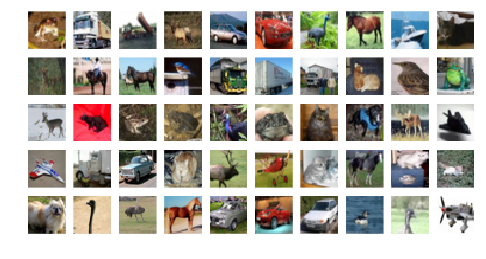

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.figure(figsize=(8, 4))
for i in range(0, 50):
    plt.subplot(5, 10, i+1)
    plt.axis('off')
    plt.imshow(imdeprocess(train_data[i]), interpolation='none')

Load the chainer and the dependencies

In [8]:
import six
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

Define the network architecture to reconstruct input images in the output layer

In [9]:
class AE(chainer.Chain):
    
    def __init__(self, n_in, n_h):
        super(AE, self).__init__(
            fc1 = L.Linear(n_in, n_h),
            fc2 = L.Linear(n_h, n_in)
        )
    
    def __call__(self, x, train=True):
        y = self.forward(x, train=train)
        self.loss = F.mean_squared_error(y, x)
        return self.loss

    def forward(self, x, train):
        self.h_data = x
        self.h_fc1 = F.dropout(F.relu(self.fc1(self.h_data)),train=train)
        self.h_fc2 = self.fc2(self.h_fc1)
        return self.h_fc2

We'll crop 6x6-sized images from the dataset.  
`n_h` defines the number of units in the middle layer.

In [10]:
size = 6
n_in = 108
n_h = 108
model = AE(n_in, n_h)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))

In [11]:
def crop(images, size=size):
    cropped = []
    for im in images:
        i , j = np.random.randint(0, 32 - size, 2)
        cropped.append(im[ : , i: i + size, j: j + size])
    return np.asarray(cropped)

In [12]:
gpuid = 0 # gpu device ID (cpu if this negative)
xp = cuda.cupy if gpuid >= 0 else np

if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()

Initialized weights in the 1st layer

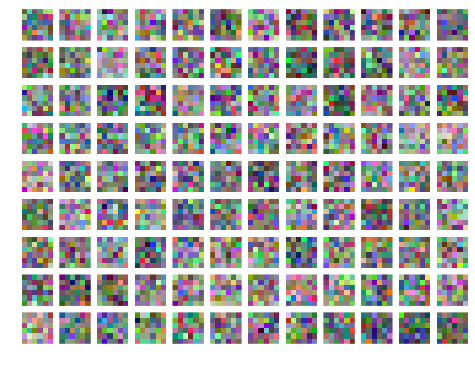

In [13]:
plt.figure(figsize=(8, 6))
for i in range(0, n_h):
    plt.subplot(9, 12, i+1)
    fmap = model.fc1.W.data[i].reshape(3, size, size)
    if gpuid >= 0:
        fmap = cuda.cupy.asnumpy(fmap)
    fmap -= fmap.min()
    fmap /= fmap.max()
    plt.imshow(fmap.transpose(1, 2, 0), interpolation='none')
    plt.axis('off')

Optimization

In [14]:
import csv

log_train = open('ae_train.log', 'w')
writer_train = csv.writer(log_train, lineterminator='\n')
writer_train.writerow(('iter', 'loss'))

log_test = open('ae_test.log', 'w')
writer_test = csv.writer(log_test, lineterminator='\n')
writer_test.writerow(('iter', 'loss', 'acc'))

In [15]:
batchsize = 100

def test(x):
    sum_loss = 0
    for i in six.moves.range(0, len(x), batchsize):
        x_batch = crop(x[i:i + batchsize]).reshape(-1, n_in)
        x_batch = chainer.Variable(xp.asarray(x_batch), volatile='auto')
        loss = model(x_batch, train=False)
        sum_loss += float(loss.data)
    return sum_loss * batchsize / len(x)

In [16]:
loss = test(test_data)
writer_test.writerow((0, loss))
print('test: loss={0:.6f}'.format(loss))

test: loss=1.369294


In [17]:
from tqdm import tqdm
n_epoch = 50
n_data = len(train_data)

# Learning loop
with tqdm(total=n_epoch) as pbar:
    for epoch in range(n_epoch):
        pbar.update(1)

        # training
        perm = np.random.permutation(n_data)
        for i in six.moves.range(0, n_data, batchsize):
            it = epoch * n_data + i + batchsize
            x_batch = crop(train_data[perm[i:i + batchsize]]).reshape(-1, n_in)
            x_batch = chainer.Variable(xp.asarray(x_batch), volatile='off')
            optimizer.update(model, x_batch)
            loss = float(model.loss.data)
            writer_train.writerow((it, loss))
            pbar.set_description('train: loss={0:.6f}'.format(loss))

        # evaluate
        loss = test(test_data)
        writer_test.writerow((it, loss))

train: loss=0.173005: 100%|██████████| 50/50 [01:01<00:00,  1.25s/it]


In [18]:
log_train.close()
log_test.close()
log_train = np.loadtxt('ae_train.log', delimiter=',', skiprows=True).transpose()
log_test = np.loadtxt('ae_test.log', delimiter=',', skiprows=True).transpose()

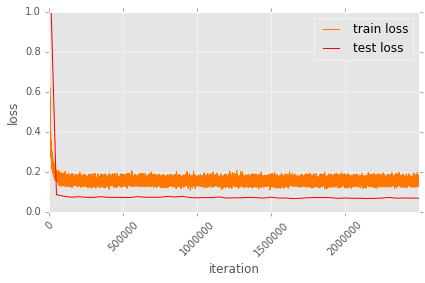

In [19]:
plt.plot(log_train[0], log_train[1], ls='-', color='#ff7700')
plt.plot(log_test[0], log_test[1], 'r-')
plt.xlabel('iteration')
plt.xticks(range(0, int(log_train[0, -1]), 500000), rotation=45)
plt.ylabel('loss')
plt.ylim(0, 1)
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1, 1), framealpha=1)
plt.tight_layout()
plt.show()

Input image (left) and reconstructed output image (right)

In [20]:
x = crop(test_data[1:2])
x -= x.min()
x /= x.max()

In [21]:
xarray = chainer.Variable(xp.asarray(x.reshape(-1, n_in)), volatile='off')
outputs = model.forward(xarray, train=False)
x_hat = outputs.data.reshape(-1, 3, size, size)
if gpuid >= 0:
    x_hat = cuda.cupy.asnumpy(x_hat)
x_hat -= x_hat.min()
x_hat /= x_hat.max()

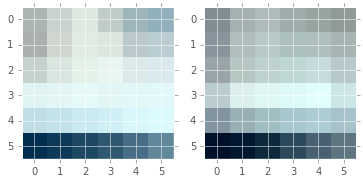

In [22]:
plt.subplot(1, 2, 1)
plt.imshow(x[0].transpose((1, 2, 0)), interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(x_hat[0].transpose((1, 2, 0)), interpolation='none')

Learned weights in the 1st layer

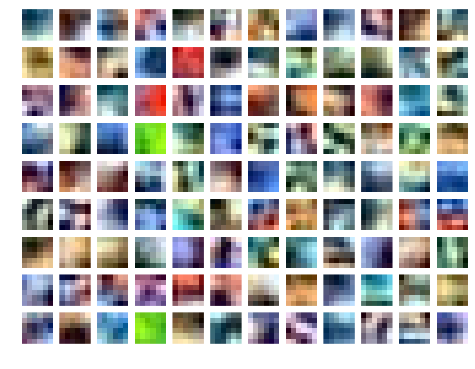

In [23]:
plt.figure(figsize=(8, 6))
for i in range(0, n_h):
    plt.subplot(9, 12, i+1)
    fmap = model.fc1.W.data[i].reshape(3, size, size)
    if gpuid >= 0:
        fmap = cuda.cupy.asnumpy(fmap)
    fmap -= fmap.min()
    fmap /= fmap.max()
    plt.imshow(fmap.transpose(1, 2, 0), interpolation='none')
    plt.axis('off')